In [9]:
import torch

ckpt_path = "D:/programs/VoiceMark/train/Log/spt_base/WatermarkTrainer_00001000.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")

print("🔎 Checkpoint type:", type(ckpt))

if isinstance(ckpt, dict):
    print("✅ Keys in checkpoint:")
    for i, k in enumerate(ckpt.keys()):
        print(f"  {i+1}. {k}")
        if i >= 20:  # 最多只打印前 20 个 key
            break
else:
    print("⚠️ Checkpoint is not a dict, type:", type(ckpt))

🔎 Checkpoint type: <class 'dict'>
✅ Keys in checkpoint:
  1. embedder
  2. detectors
  3. optim_embedder
  4. optim_detectors
  5. scheduler_embedder
  6. scheduler_detectors
  7. best_dev_loss


In [10]:
from example.watermark import embed_watermark, decode_watermark

In [11]:
from example.audio import load_audio, play_audio, plot_waveform_and_specgram
#
# waveform, sr = load_audio("../audios/1.wav", target_sr=16000)
# print(waveform.shape, sr)

In [12]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())

    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()
print(audio.shape, sr)

torch.Size([1, 167226]) 22050


D:\programs\VoiceMark\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [13]:
# audio, sr = torchaudio.load("../audios/fake_audio.wav")

In [14]:
audio.shape, sr

(torch.Size([1, 167226]), 22050)

In [15]:
# import torch
#
# length = 72000
# num_gaps = 20
# gap_ratio = 0.02
# gap_length = int(length * gap_ratio)
# sr = 24000
#
# # 生成随机音频 [-0.1, 0.1]
# audio = (torch.rand(length) * 0.2 - 0.1).float()
#
# # 随机生成 5 处空白
# for _ in range(num_gaps):
#     start = torch.randint(0, length - gap_length, (1,)).item()
#     end = start + gap_length
#     audio[start:end] = 0.0
#
# audio = audio.unsqueeze(0)
#
# print(audio.shape)  # torch.Size([72000])

In [16]:
play_audio(audio, sr)

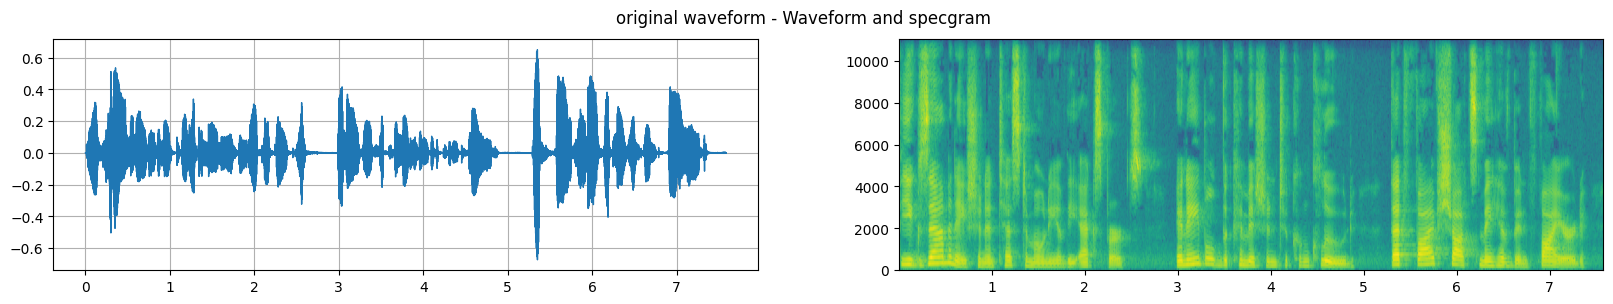


This is likely a watermarked audio: 0.5676152110099792, message: 1011000011000110


In [17]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

plot_waveform_and_specgram(audio, sr, "original waveform")
decode_watermark(audio, sr)
result, message = decode_watermark(audio, sr)
print(f"\nThis is likely a watermarked audio: {result}, message: {message}")

In [18]:
watermarked_audio = embed_watermark(audio, sample_rate=sr, message="1000010101010011")

In [19]:
play_audio(watermarked_audio, 16000)

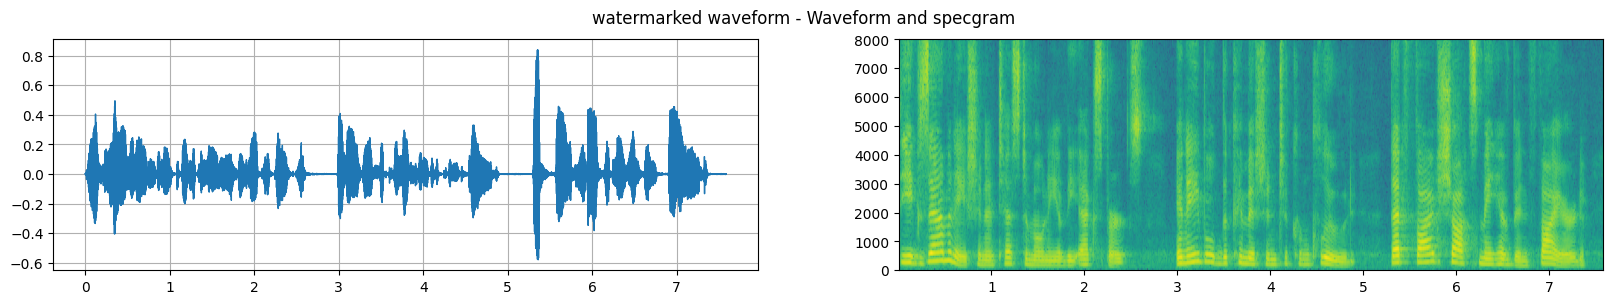


This is likely a watermarked audio: 0.40116629004478455, message: 1111011010101001


In [20]:
plot_waveform_and_specgram(watermarked_audio, 16000, "watermarked waveform")
result, message = decode_watermark(watermarked_audio.squeeze(0), sr)
print(f"\nThis is likely a watermarked audio: {result}, message: {message}")

In [69]:
from example.attacks import AudioEffects as af

In [ ]:
speed = af.speed(watermarked_audio, sample_rate=sr, speed_range=(0.9, 1.1))
plot_waveform_and_specgram(speed, sample_rate=sr, title="Audio with speed filter")
play_audio(speed, sr)

In [ ]:
result, message = decode_watermark(speed.squeeze(0), sr)
print(f"Detection Result with Speed Filter: {result, message}")

### 用LJSpeech检测voice mark的水印检测正确率

In [39]:
import os
import torch
import torchaudio
import soundfile as sf
from tqdm import tqdm

# 假设你的方法
# embed_watermark(audio, sample_rate)
# decode_watermark(audio, sample_rate) -> (result, message)
# 其中 result = True/False

LJSPEECH_DIR = r"D:\dataset\LJSpeech-1.1\wavs"   # LJSpeech wav 文件夹
SAVE_DIR = r"D:\dataset\LJSpeech-1.1\LJSpeech_watermarked_voicemark"
os.makedirs(SAVE_DIR, exist_ok=True)

num_files = 100

# 统计
TP, TN, FP, FN = 0, 0, 0, 0
message = "1111111100000000"

# 遍历 LJSpeech
files = sorted(os.listdir(LJSPEECH_DIR))[:num_files]

for fname in tqdm(files, desc="Processing"):
    filepath = os.path.join(LJSPEECH_DIR, fname)

    # 读取音频
    audio, sr = torchaudio.load(filepath)   # audio: [1, T]

    # ---------- 原始音频检测 ----------
    try:
        result_orig, msg_orig = decode_watermark(audio, sr)
    except Exception as e:
        print(f"[原始音频检测失败] {fname}: {e}")
        continue

    if msg_orig == message:
        FP += 1   # 没水印却检测到 → 误报
    else:
        TN += 1   # 没水印没检测到 → 正确

    # ---------- 嵌入水印 ----------
    watermarked_audio = embed_watermark(audio, sample_rate=sr, message=message)
    watermarked_audio = watermarked_audio.squeeze(0).squeeze(0)

    # 保存水印音频
    save_path = os.path.join(SAVE_DIR, fname)
    sf.write(save_path, watermarked_audio.cpu().numpy().astype('float32'), sr)

    # ---------- 检测水印音频 ----------
    try:
        result_wm, msg_wm = decode_watermark(watermarked_audio.unsqueeze(0), sr)
    except Exception as e:
        print(f"[水印音频检测失败] {fname}: {e}")
        continue

    if msg_wm == message:
        TP += 1   # 有水印且检测到 → 正确
    else:
        FN += 1   # 有水印但没检测到 → 漏报


# ---------- 计算指标 ----------
ACC = (TP + TN) / (TP + TN + FP + FN)
FAR = FP / (FP + TN) if (FP + TN) > 0 else 0.0

print(f"统计结果 (基于 {num_files} 个样本):")
print(f"TP = {TP}, TN = {TN}, FP = {FP}, FN = {FN}")
print(f"ACC = {ACC:.4f}")
print(f"FAR = {FAR:.4f}")

Processing: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

统计结果 (基于 100 个样本):
TP = 0, TN = 100, FP = 0, FN = 100
ACC = 0.5000
FAR = 0.0000
